(haxby-dataset)=
# The Haxby dataset

## Downloading the data
 In the field of functional magnetic resonance imaging (fMRI), one of the first studies which have demonstrated the feasibility of brain decoding was the study by Haxby and colleagues (2001) {cite:p}`Haxby2001-vt`. Subjects were presented with various images drawn from different categories. In this tutorial, we will try to decode the category of the image presented to the subject from brain data. We are first going to use nilearn to download one subject (number 4) from the Haxby dataset.

In [1]:
import os
from nilearn import datasets
# We are fetching the data for subject 4
data_dir = os.path.join('..', 'data')
sub_no = 4
haxby_dataset = datasets.fetch_haxby(subjects=[sub_no], fetch_stimuli=True, data_dir=data_dir)
func_file = haxby_dataset.func[0]

/opt/hostedtoolcache/Python/3.8.12/x64/lib/python3.8/site-packages/nilearn/datasets/__init__.py:86: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "



Dataset created in ../data/haxby2001



 ...done. (0 seconds, 0 min)


 ...done. (0 seconds, 0 min)


Downloaded 114876416 of 329954386 bytes (34.8%,    1.9s remaining)

Downloaded 252960768 of 329954386 bytes (76.7%,    0.6s remaining)

 ...done. (3 seconds, 0 min)


Extracting data from ../data/haxby2001/622d4f5d4b8f14a567901606c924e90d/subj4-2010.01.14.tar.gz...

.. done.


 ...done. (0 seconds, 0 min)
Extracting data from ../data/haxby2001/5cd78c74b711572c7f41a5bddb69abca/stimuli-2010.01.14.tar.gz..... done.


## Visualizing the data
The data includes `nii` files, which contains images of brain volumes, either anatomical or functional. We can examine one functional volume using nilearn's plotting tools. Because fmri data are 4D we use [nilearn.image.mean_img](https://nilearn.github.io/modules/generated/nilearn.image.mean_img.html#nilearn.image.mean_img) to extract the average brain volume.


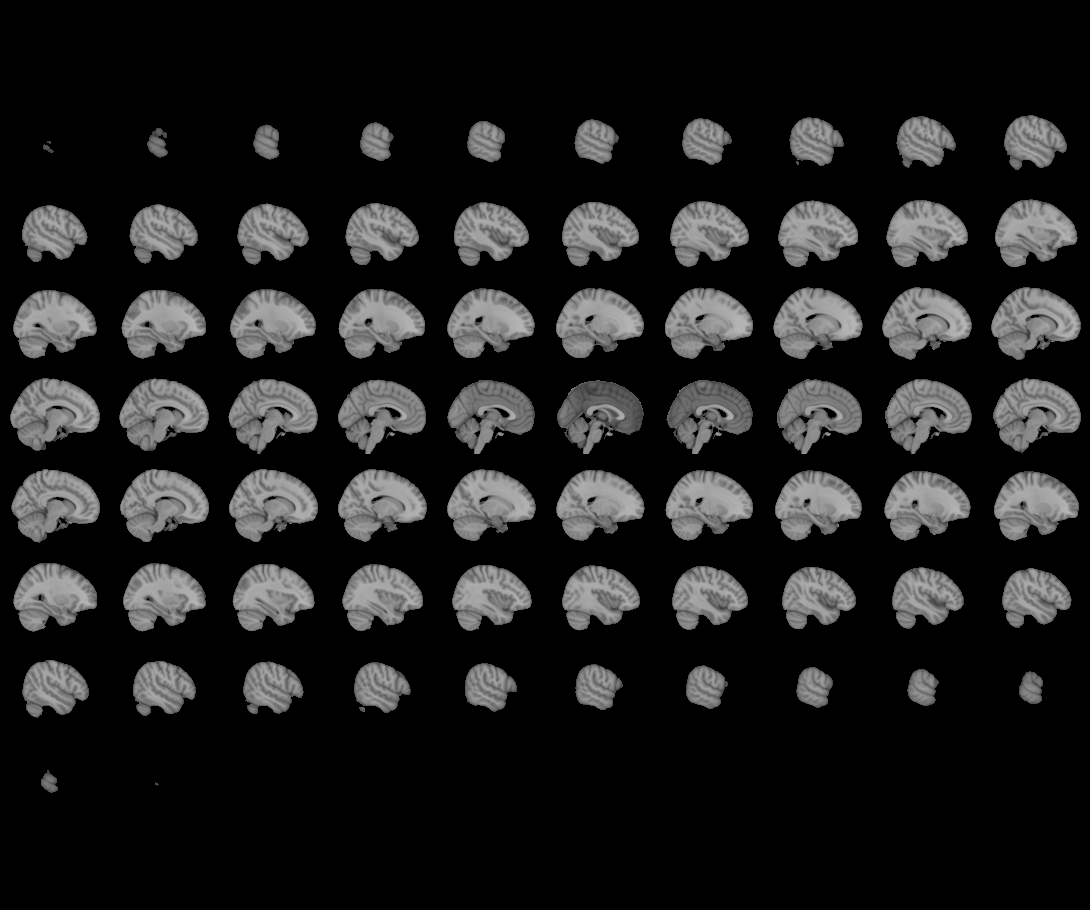
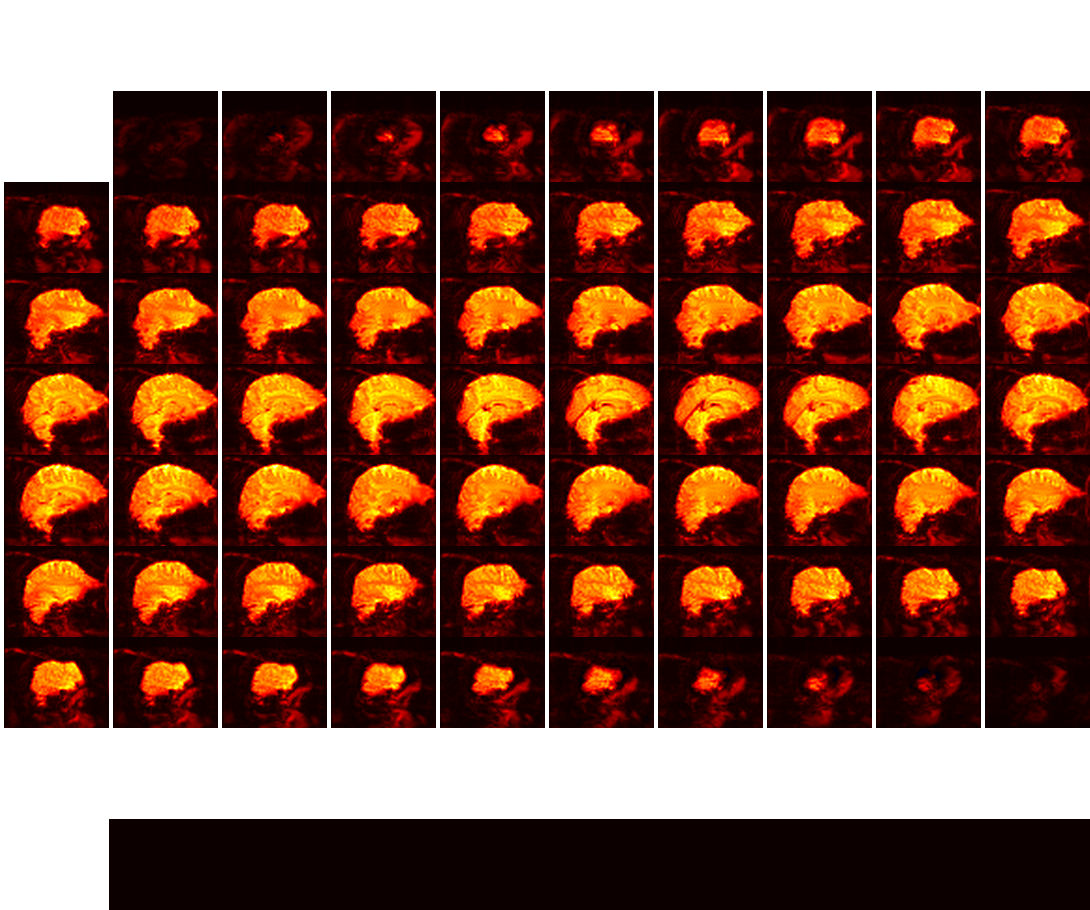

In [2]:
from nilearn import plotting
from nilearn.image import mean_img
plotting.view_img(mean_img(func_file), threshold=None)

Note that it is very hard to see the anatomy of the brain with that type of image. But it is not designed to capture brain anatomy, but rather changes of brain activity over time, through the coupling of neuronal activity with the oxygenation of blood vessels.

```{admonition} Interactive viewer
:class: tip
The viewer `plotting.view_img` is interactive. You can click on the brain volume to explore different slices. You can learn about the three anatomical planes: sagittal (`x`), coronal (`y`) and axial (`z`) in the [wikipedia article](https://en.wikipedia.org/wiki/Anatomical_plane).
```

## Preparing the fMRI data
```{figure} haxby_data/masker.png
---
width: 800px
name: masker-fig
---
A `Masker` object is used to convert a 4D volume (space + time) into a data array, where each column is a voxel or brain region (features) and each row is a time point (samples). Figure from the [nilearn documentation](https://nilearn.github.io/stable/manipulating_images/masker_objects.html).
```
Instead of keeping the fMRI data as a 4D array (3D spatial coordinates + time), we are going to extract the time series associated with a mask of the ventral temporal cortex. This mask has been generated as part of the Haxby et al. (2001) study, and highlights a part of the brain specialized in the processing of visual information, and which contains areas sensitive to different types of image categories.

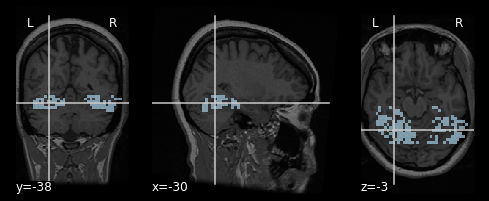

In [3]:
mask_filename = haxby_dataset.mask_vt[0]
# Let's visualize it, using the subject's anatomical image as a
# background
plotting.plot_roi(mask_filename, bg_img=haxby_dataset.anat[0],
                  cmap='Paired')

We use one of the nilearn maskers to extract the fMRI time series associated just with this mask:

In [4]:
from nilearn.input_data import NiftiMasker
masker = NiftiMasker(mask_img=mask_filename, standardize=True, detrend=True)
# Selecting data
X = masker.fit_transform(func_file)
print(X.shape)

(1452, 675)


We can see that the dataset has 1452 time samples (number of rows) and 675 voxels in the mask (number of columns).

```{admonition} Nilearn maskers
:class: tip
Nilearn maskers are very versatile and offer many approaches to extract a time series array from 4D data, as well as reshape back an array into a series of brain volumes. You can learn more about nilearn maskers in this [documentation](https://nilearn.github.io/stable/manipulating_images/masker_objects.html).
```

## Preparing the cognitive annotations

Now, we are going to extract cognitive annotations, that is values which tell us what type of images the subject was viewing at each time point. Let's look at the first 20 annotations:

In [5]:
import pandas as pd
behavioral = pd.read_csv(haxby_dataset.session_target[0], delimiter=' ')
display(behavioral.iloc[0:20])

,labels,chunks
0,rest,0
1,rest,0
2,rest,0
3,rest,0
4,rest,0
5,rest,0
6,face,0
7,face,0
8,face,0
9,face,0


So let's extract the labels for each time points. We can check that the number of annotations match exactly the number of samples we had in `X`. We can also check all the annotation categories available.

In [6]:
y = behavioral['labels']
categories = y.unique()
print(categories)
print(y.shape)
print(X.shape)

['rest' 'face' 'chair' 'scissors' 'shoe' 'scrambledpix' 'house' 'cat'
 'bottle']
(1452,)
(1452, 675)


These annotations correspond to the category of the image subjects were watching at each time point. Samples of images for each category are shown below:

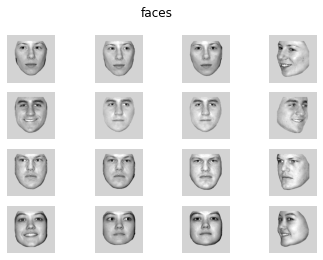

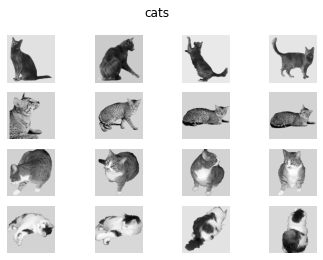

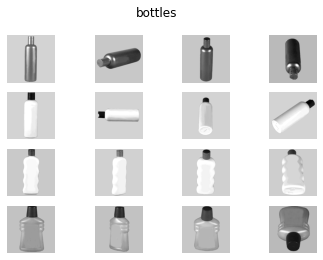

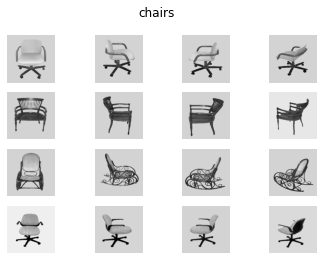

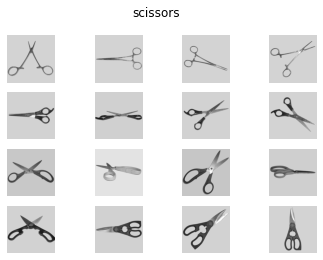

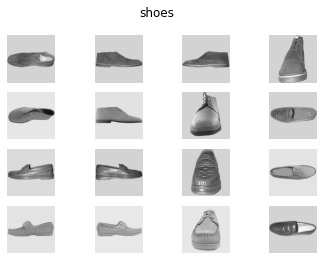

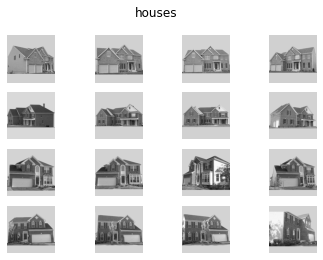

In [7]:
import matplotlib.pyplot as plt

from nilearn import datasets
from nilearn.plotting import show

stimulus_information = haxby_dataset.stimuli

for stim_type in stimulus_information:
  # skip control images, there are too many
  if stim_type != 'controls':

     file_names = stimulus_information[stim_type]
     file_names = file_names[0:16]
     fig, axes = plt.subplots(4, 4)
     fig.suptitle(stim_type)

     for img_path, ax in zip(file_names, axes.ravel()):
         ax.imshow(plt.imread(img_path), cmap=plt.cm.gray)

     for ax in axes.ravel():
         ax.axis("off")

show()

Note that for each image category, a number of scrambled images were also presented.

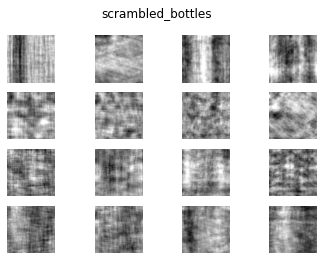

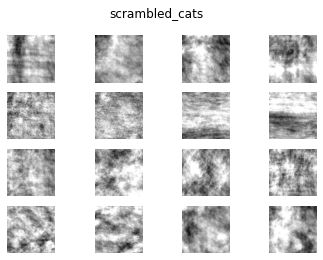

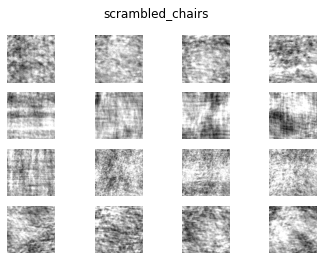

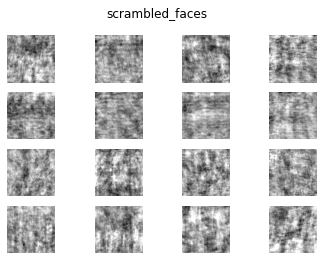

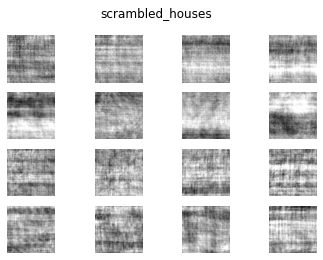

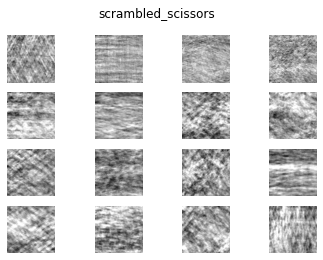

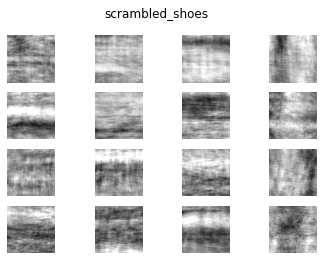

In [8]:
for stim_num in range(len(stimulus_information['controls'])):
    stim_type = stimulus_information['controls'][stim_num][0]
    file_names = stimulus_information['controls'][stim_num][1]  
    file_names = file_names[0:16]
    fig, axes = plt.subplots(4, 4)
    fig.suptitle(stim_type)

    for img_path, ax in zip(file_names, axes.ravel()):
     ax.imshow(plt.imread(img_path), cmap=plt.cm.gray)

    for ax in axes.ravel():
     ax.axis("off")

show()

## References

```{bibliography}
:filter: docname in docnames
```
```